# Initial oos exploration

In [1]:
import numpy as np
from graspy.simulations import rdpg
from graspy.plot import heatmap, pairplot

### Generate RDPG

Create some augmented graph $A$, which is the adjacency matrix of $\hat{G} = ([n] \cup {v}, E \cup E_v)$, where $E_v$ denotes the set of edges between an out-of-sample vertex $v$ and the vertices of $G$.

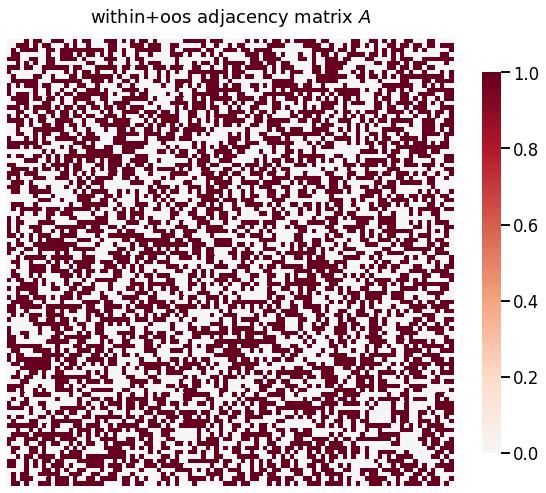

In [2]:
# n is total nodes, n_hat is within-sample nodes
# define parameters
n = 101
n_hat = n-1
d = 2

# generate matrix
mat = np.full((n, d), .5)
A = rdpg(mat)
heatmap(A, title="within+oos adjacency matrix $A$");

### Embed everything with ASE

First, we get the base-truth embedding.
Embed $A$, then plot.  
$X$ is the latent position matrix containing both the in-sample and oos nodes.

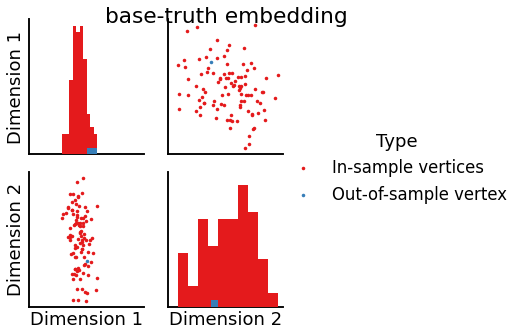

In [3]:
from graspy.embed import AdjacencySpectralEmbed as ASE
import matplotlib.pyplot as plt

# get labels
labels = ["In-sample vertices"] * n_hat + ["Out-of-sample vertex"]

# embed both in-sample and oos to get the true latent position for v
ase = ASE(n_components=2)
ase.fit(A)
X = ase.latent_left_

# plot
ax1 = pairplot(X, labels=labels, alpha=1, 
              title="base-truth embedding")

### LLS

Now, we create a new embedding X_hat, which only contains latent positions of in-sample nodes.  
Also create $\vec{a}$, the out-of-sample node vector.  
The goal is to use only the information in $\hat{X}$ and in $\vec{a}$ to find some embedding $w$ which approximates the true latent position of $\vec{a}$.  
The LLS approach is to embed the oos vertex $v$ (whose vector is $\vec{a}$) as the least-squares solution to $\hat{X}w = \vec{a}$. Meaning, we solve the equation  
$\min{w\in R^d}\sum_{i=1}^n (a_i-\hat{X}_i^Tw)^2$

where $a_i$ denotes the i-th component of the vector $\vec{a}$

#### embed only in-sample with ASE

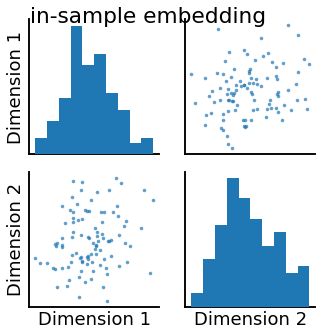

In [4]:
# create in-sample adjacency matrix and an oos vector
A_hat = A[:-1, :-1]
a = A[-1, :-1]  # doesn't contain the 0-value self-loop

# embed
ase = ASE(n_components=2)
ase.fit(A_hat)

# grab latent positions and singular values
X_hat = ase.latent_left_.copy()
eig_values = ase.singular_values_.copy()

ax2 = pairplot(X_hat, title="in-sample embedding")
# TODO: plot X on top of this to see if there are differences besides just the oos vertex

#### note
I don't really understand how the code below is the same as  
$\min{w\in R^d}\sum_{i=1}^n (a_i-\hat{X}_i^Tw)^2$

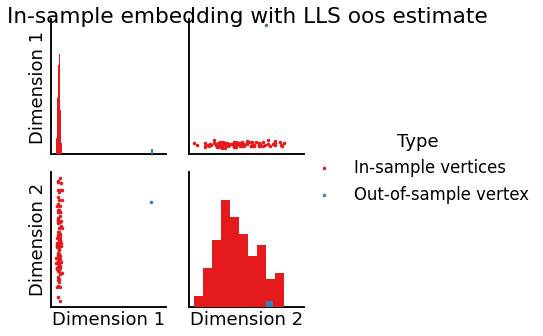

In [5]:
# hayden's code to compute the embedding -- one-liner?
w = a @ X_hat @ np.diag(1/np.sqrt(eig_values))  # I think this is w?
X_hat_augmented = np.vstack((X_hat, w))

# I clearly fucked up
ax3 = pairplot(X_hat_augmented, labels=labels, alpha=1, 
              title="In-sample embedding with LLS oos estimate")

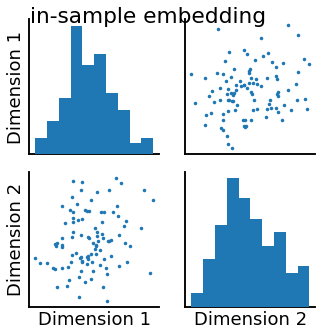

In [11]:
# pairplot(X, labels=labels, alpha=1, title="base-truth embedding")
pairplot(X_hat, title="in-sample embedding", alpha=1)
plt.savefig("in-sample-embedding.png")
# ax3 = pairplot(X_hat_augmented, labels=labels, alpha=1, 
#               title="In-sample embedding with LLS oos estimate")
